In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from regional_K.cpt_functions import setup_grid
import matplotlib as mpl

from SALib.analyze import sobol
from sklearn.decomposition import PCA

fill_df = pd.read_csv('./from_sherlock/new_20250226/sensitivity_fill_new.csv', index_col=0)
fill = fill_df.values

ybm_df = pd.read_csv('./from_sherlock/new_20250226/sensitivity_ybm_new.csv', index_col=0)
ybm = ybm_df.values

In [2]:
problem = {
    'num_vars': 7,
    'names': ['Detection', 'Assignment', 'K_source','Preprocess','a','b', 't_ref'],  #  
    'bounds': [[0, 1],  # map to Hudson2023, change point
               [0, 1], # MS, MS_AF
               [0, 1],  # map to empirical, table
               [0, 1],  # binary, 0 for no preprocessing, 1 for preprocessing
               [0, 2],  # a
               [14,24],  # b
               [3,10]  # t_ref
               ]}

## converted K values to correct for log error in all sensitivity
K_df = pd.read_csv('./from_sherlock/new_20250226/sensitivity_save_K_new.csv', index_col=0)
indices = np.where(abs(K_df['hk_m_day_1'] - 10**(-1.5)) > 0.0000001)[0]
K_df.loc[indices,:] = 10**K_df.loc[indices,:]

#### Run PCA on fill depth and K

In [3]:
pca = PCA()
pca.fit(fill)

# find where the explained variance is 95%
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

pca = PCA(n_components=max(d,6))  # This is about 95% of the variance
fill_pca = pca.fit_transform(fill)  # Transformed output: shape (N, 16)

# Explained variance for each component
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", np.sum(explained_variance))
print("Explained variance ratio:", explained_variance)


## Here find the output for the sensitivity analysis
# Y_k = save_K['hk_m_day_0'].to_numpy()
Y_t = fill_pca
Si_0   = sobol.analyze(problem, Y_t[:,0])

results = []
for i in range(d):
    Si = sobol.analyze(problem, Y_t[:, i],calc_second_order=True)
    results.append(Si)

num_pcs = len(results)  # Number of PCs
num_vars = len(problem['names'])  # Number of variables
S1_matrix = np.array([Si['S1'] for Si in results])  # Shape: (num_pcs, num_vars)



4
Explained variance ratio: 0.9785523449650493
Explained variance ratio: [0.83207855 0.05976844 0.03744035 0.02196273 0.01511101 0.01219126]


c:\Users\Emily\miniconda3\envs\Kh_env\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [4]:
# sum Y_t over the first 4 pcs and make a new output matrix pc_sum
pc_sum = np.sum(Y_t[:,:4], axis=1)


In [5]:
# spatially plot the PCs
points = setup_grid(geoplot='./geojson/alameda_city.geojson')
points = points.to_crs('EPSG:4326')
loadings = pca.components_.T  # Shape: (n_points, n_pcs)
num_pcs_to_plot = 6  # First 6 PCs
for i in range(num_pcs_to_plot):
    points[f'PC_{i + 1}'] = loadings[:, i]

vmin = -max(abs(points[[f'PC_{i + 1}' for i in range(num_pcs_to_plot)]].min().min()),points[[f'PC_{i + 1}' for i in range(num_pcs_to_plot)]].max().max())
vmax = -vmin  # Symmetric around 0


c:\users\emily\documents\github\hydro_conduct_working\regional_k\regional_K\cpt_functions.py:420: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  points = pd.concat([points, pd.DataFrame([[lat, lon, utmX, utmY]], columns=['lat', 'lon', 'utmX', 'utmY'])])


C:\Users\Emily\AppData\Local\Temp\ipykernel_47332\462885166.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


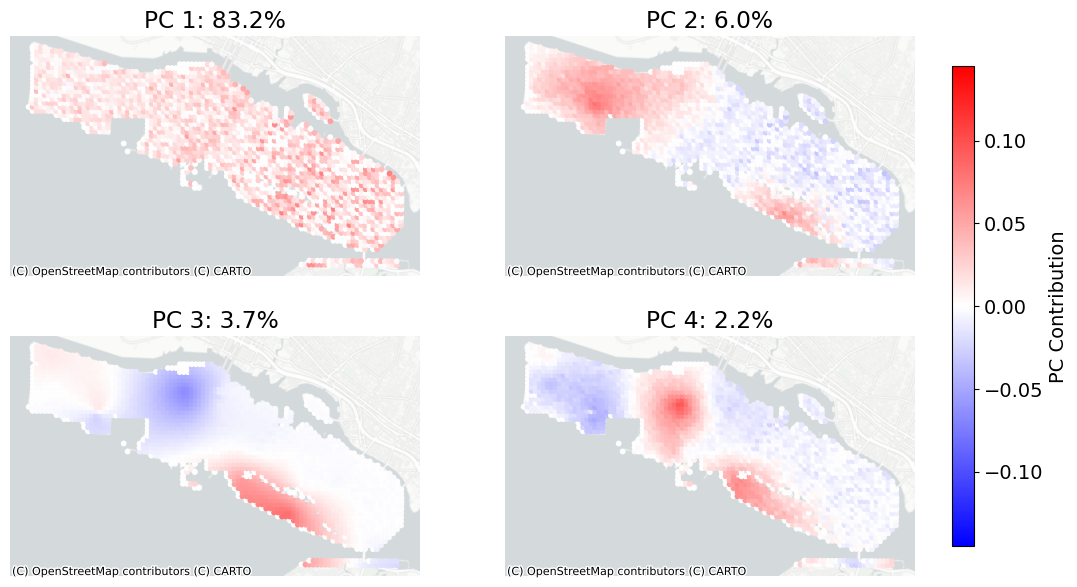

In [6]:
# Create the subplots
fig = plt.figure(figsize=(11, 6))
plt.rcParams.update({'font.size': 14})

# Define custom axes positions
axes_positions = [
    [0.05, 0.55, 0.4, 0.4],  # Top-left
    [0.50, 0.55, 0.4, 0.4],  # Top-right
    [0.05, 0.05, 0.4, 0.4],  # Bottom-left
    [0.50, 0.05, 0.4, 0.4]   # Bottom-right
]

axes = [fig.add_axes(pos) for pos in axes_positions]  # Create axes manually

num_pcs_to_plot = 4  # First 4 PCs

# Plot each PC's contribution
for i in range(num_pcs_to_plot):
    ax = axes[i]
    points.plot(
        column=f'PC_{i + 1}', 
        ax=ax, 
        cmap='bwr', 
        legend=False, 
        vmin=vmin, 
        vmax=vmax, 
        markersize=10
    )
    ctx.add_basemap(ax, crs=points.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
    ax.set_title(f'PC {i + 1}: {explained_variance[i]*100:.1f}%')
    ax.axis('off')


# Add a shared colorbar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Adjust the colorbar position
cbar = mpl.colorbar.ColorbarBase(
    cbar_ax, 
    cmap='bwr', 
    norm=norm, 
    orientation='vertical', 
    label='PC Contribution'
)

plt.tight_layout()
plt.savefig('./figures/pc_maps.png', format='png', dpi=1000)
plt.savefig('./figures/pc_maps.pdf', format='pdf', dpi=1000)

plt.show()


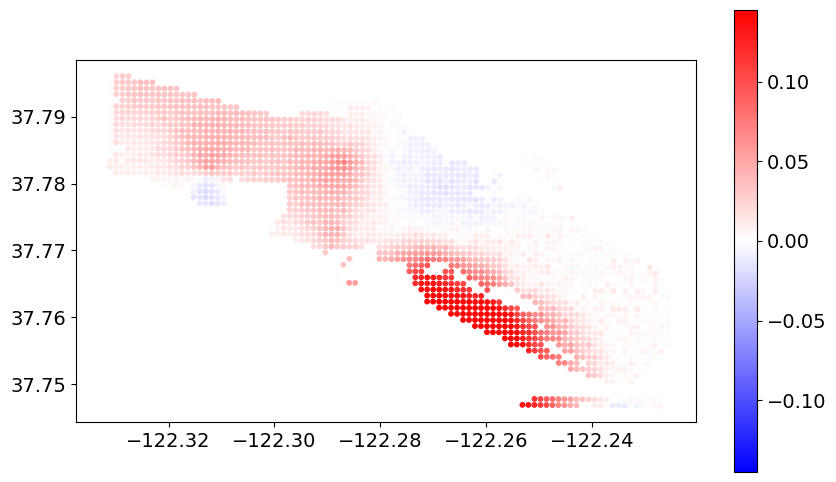

In [7]:
# make a map that is a sum of the first three PCs
points['PC_sum'] = points[[f'PC_{i + 1}' for i in range(4)]].sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
points.plot(column='PC_sum', ax=ax, cmap='bwr', legend=True, markersize=10, vmin=vmin, vmax=vmax)
# ctx.add_basemap(ax, crs=points.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)

plt.show()

In [8]:
# run the same sensitivity for the K values
K_df = pd.read_csv('./from_sherlock/new_20250226/sensitivity_save_K_new.csv', index_col=0)
Y_k = (K_df['hk_m_day_0'].values - np.mean(K_df['hk_m_day_0'].values))/ np.std(K_df['hk_m_day_0'].values)  #np.log

Si_k   = sobol.analyze(problem, Y_k,calc_second_order=True)

c:\Users\Emily\miniconda3\envs\Kh_env\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


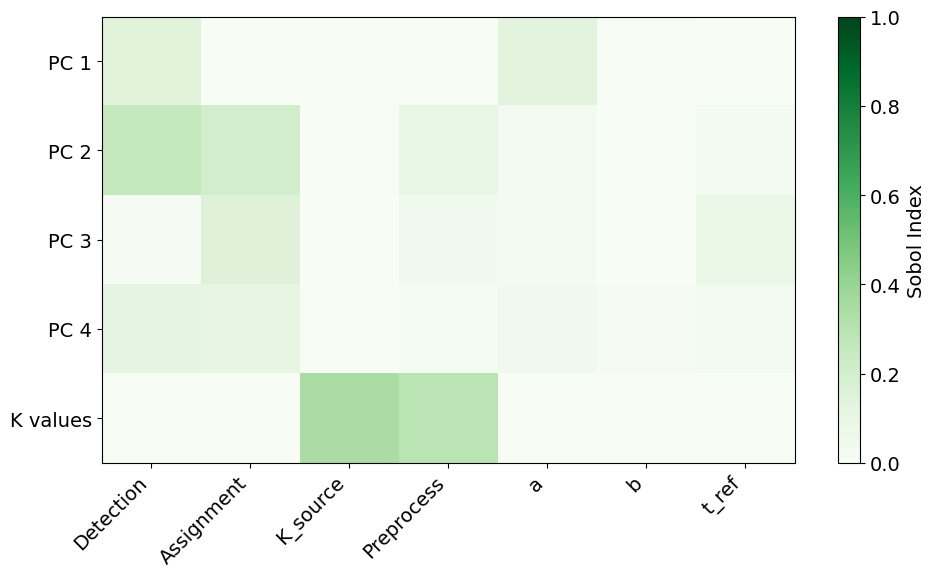

In [9]:
## append with si_K and plot
Si_list = S1_matrix.tolist()
Si_list.append(Si_k['S1'])
S1_matrix = np.array(Si_list)

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(S1_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_yticks(range(num_pcs+1))
ax.set_yticklabels([f'PC {i+1}' for i in range(num_pcs)] + ['K values'])
fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')

# Add overall title
# fig.suptitle('Sobol Indices', fontsize=16)
plt.tight_layout()
plt.show()

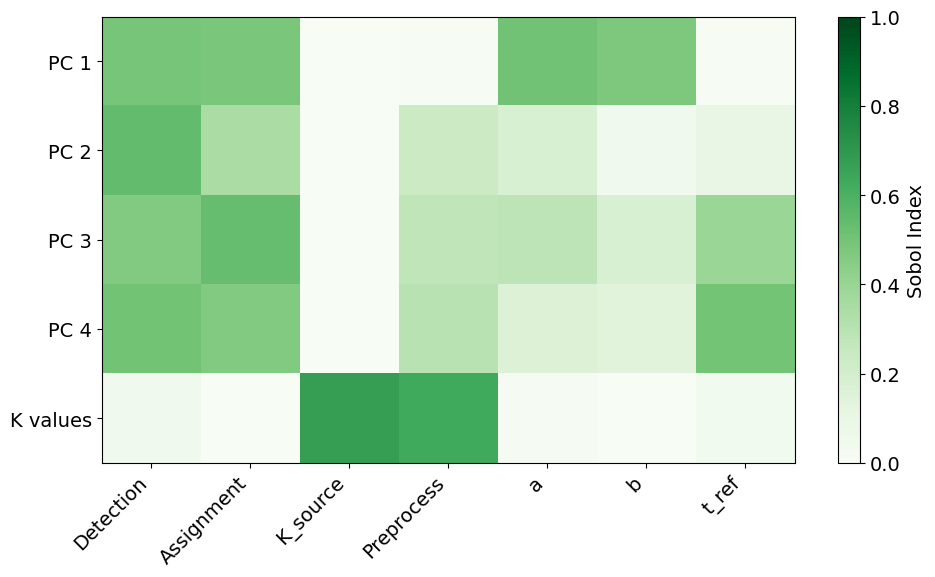

In [10]:
## Plot the higher order sobol for PCs and K
ST_matrix = np.array([Si['ST'] for Si in results])  # Shape: (num_pcs, num_vars)
ST_list = ST_matrix.tolist()
ST_list.append(Si_k['ST'])
ST_matrix = np.array(ST_list)

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(ST_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_yticks(range(num_pcs+1))
ax.set_yticklabels([f'PC {i+1}' for i in range(num_pcs)] + ['K values'])
fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')

# Add overall title
# fig.suptitle('Sobol Indices', fontsize=16)
plt.tight_layout()
plt.show()

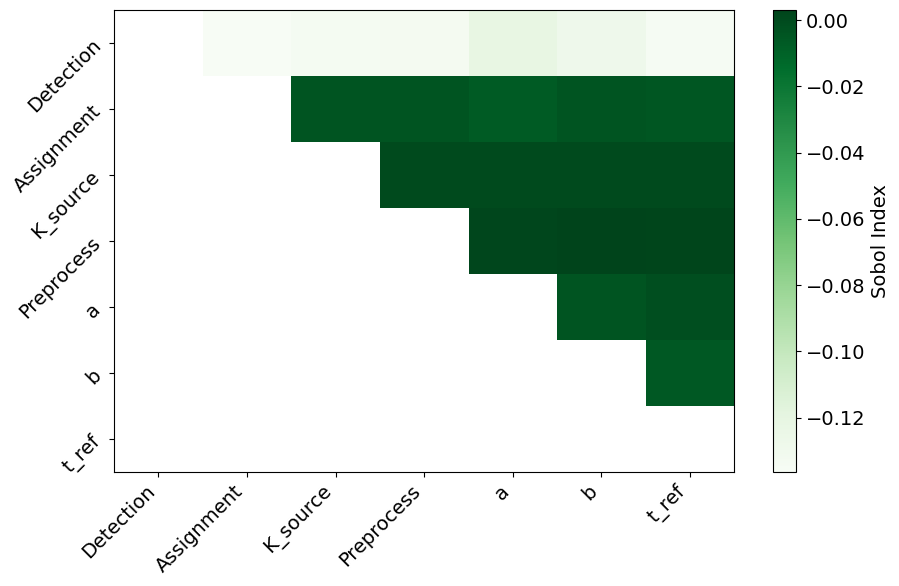

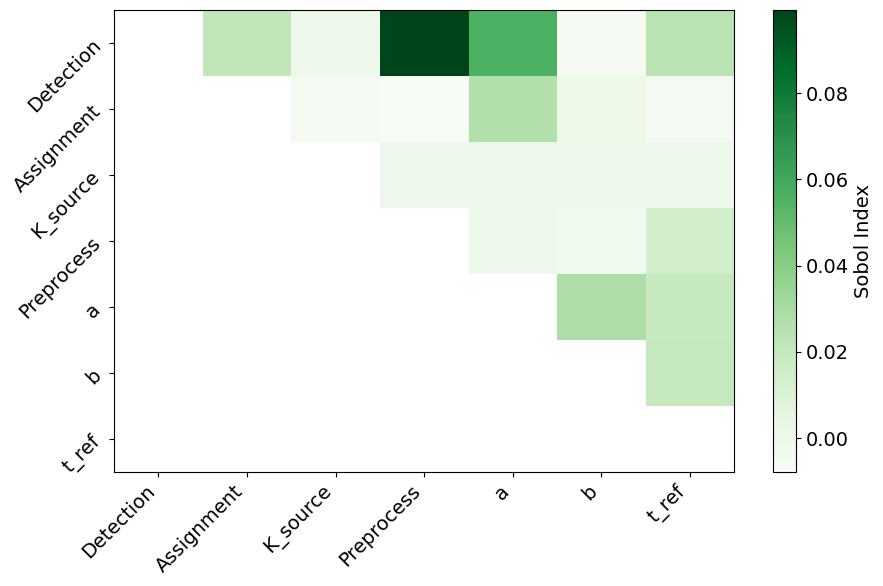

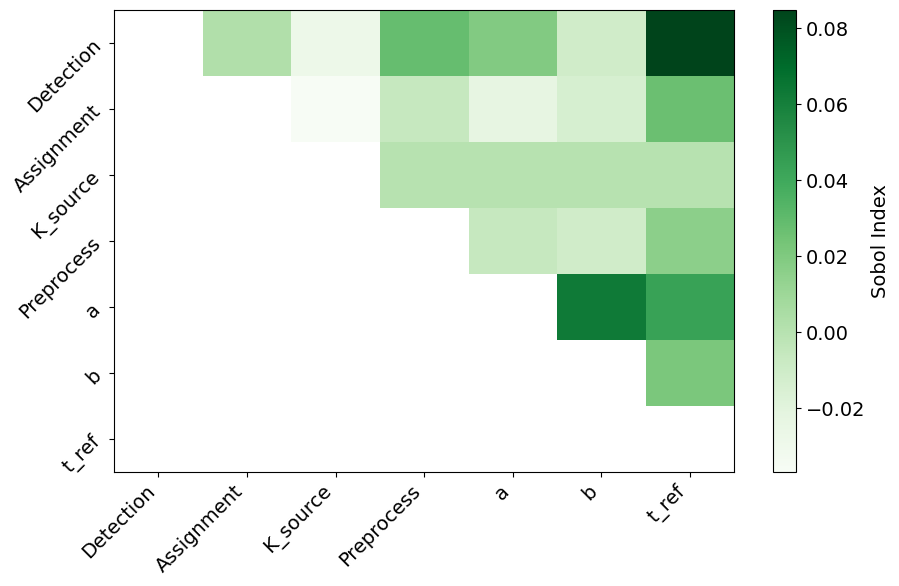

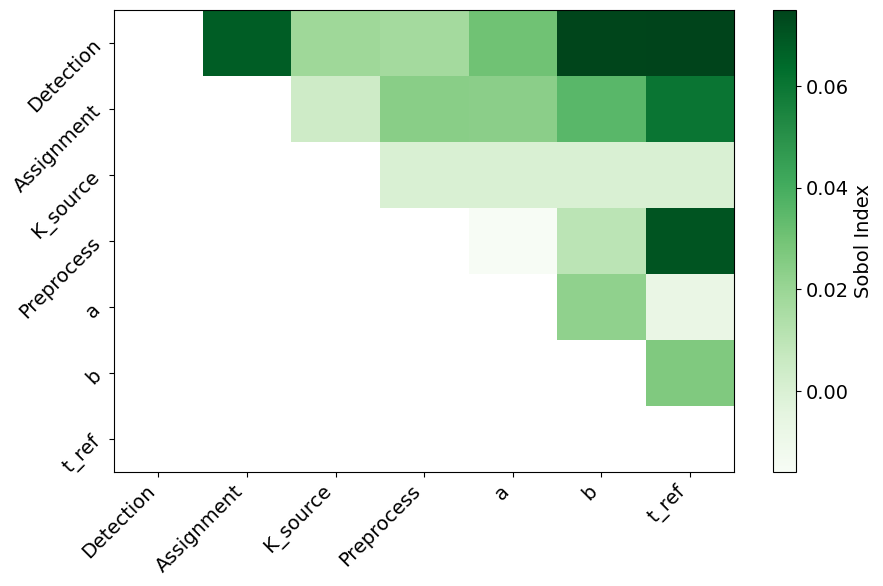

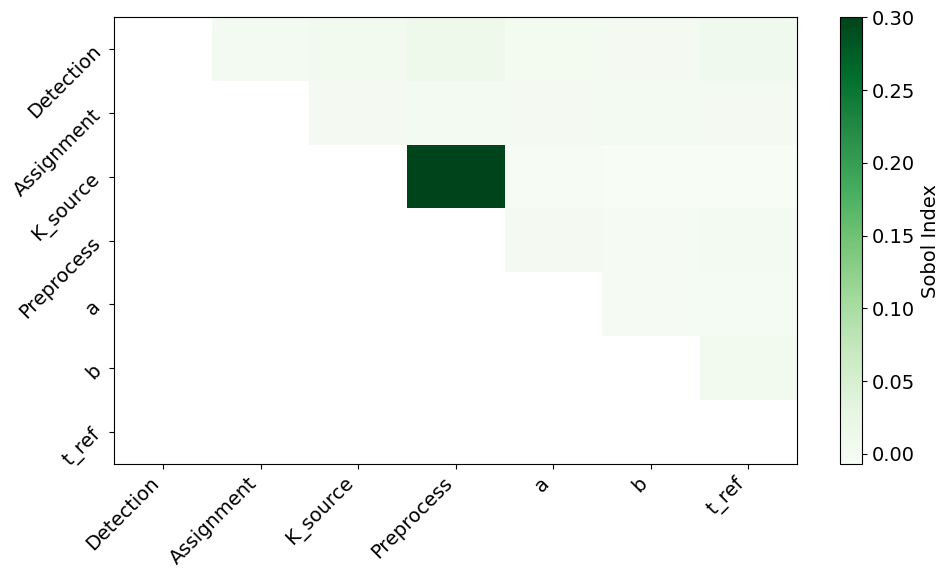

In [11]:
## plot second order sobol indices
S2_matrix = np.array([Si['S2'] for Si in results])  # Shape: (num_pcs, num_vars, num_vars)
S2_list = S2_matrix.tolist()
S2_list.append(Si_k['S2'])
S2_matrix = np.array(S2_list)
for indx in range(5):
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(S2_matrix[indx,:,:], aspect='auto', cmap='Greens', interpolation='nearest') #, vmin=0) #,vmax=1)
    ax.set_xticks(range(num_vars))
    ax.set_xticklabels(problem['names'], rotation=45, ha='right')
    ax.set_yticks(range(num_vars))
    ax.set_yticklabels(problem['names'], rotation=45, ha='right')
    fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')

# Add overall title
# fig.suptitle('Sobol Indices', fontsize=16)
plt.tight_layout()
plt.show()


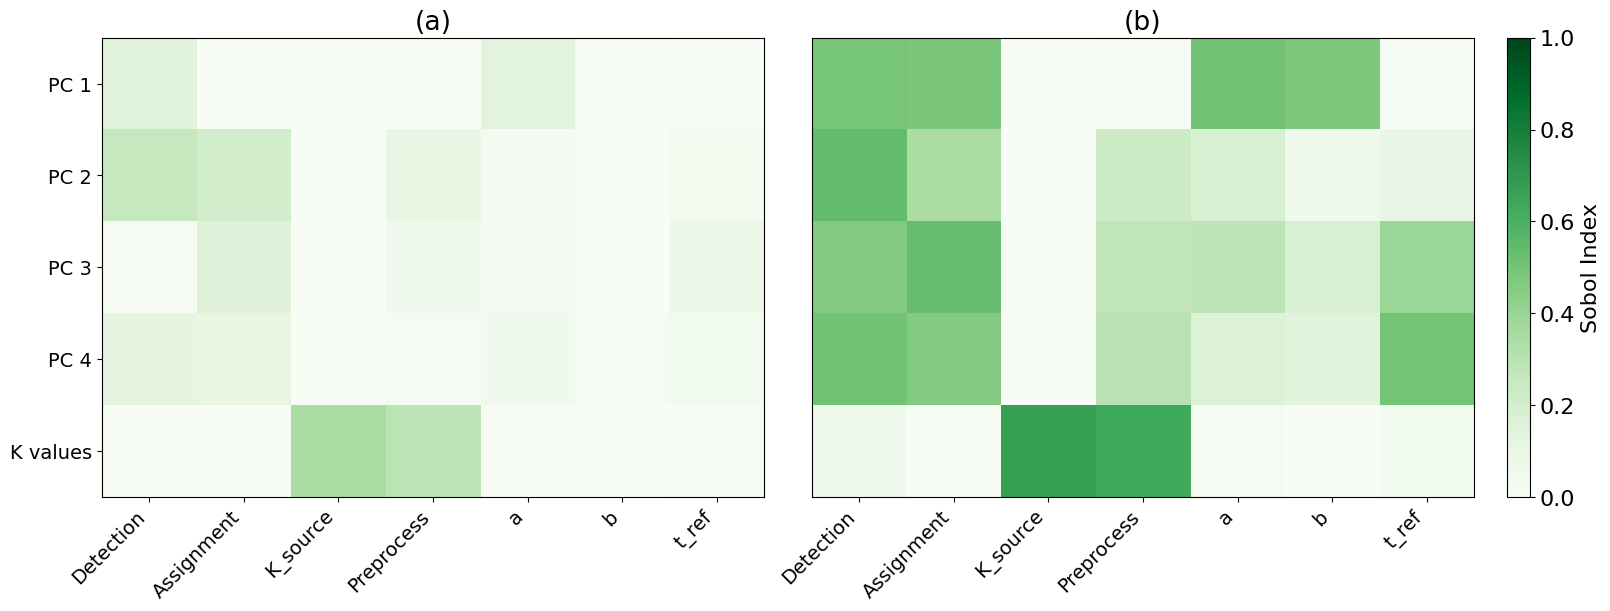

In [ ]:
## make a plot with two side-by side subfigures that are s1 and sT
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
plt.rcParams.update({'font.size': 16})
axes = axes.flatten()
ax = axes[0]
im = ax.imshow(S1_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_yticks(range(num_pcs+1))
ax.set_yticklabels([f'PC {i+1}' for i in range(num_pcs)] + ['K values'])
# fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('(a)')

ax = axes[1]
im = ax.imshow(ST_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
# remove y ticks
ax.set_yticks([])
fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('(b)')
plt.savefig('./figures/sobol_indices.png', format='png', dpi=1000,bbox_inches='tight')
plt.savefig('./figures/sobol_indices.pdf', format='pdf', dpi=1000,bbox_inches='tight')


In [13]:
categorical_samples_df = pd.read_csv('./from_sherlock/new_20250226/sensitivity_inputs.csv', index_col=0)
# categorical_samples_df


The sensitivity heatmaps are the exact same whether heuristic is included or removed.

#### Now run the sensitivity on the K value and thickness of ybm across the island

In [14]:
pca = PCA()
pca.fit(ybm)

# find where the explained variance is 95%
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

2


In [15]:
# # Assume `outputs` is the spatial output matrix with shape (N, 2430)
pca = PCA(n_components=max(d,3))  # This is over 95% of the variance
ybm_pca = pca.fit_transform(ybm)  # Transformed output: shape (N, 16)

# Explained variance for each component
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", np.sum(explained_variance))
print("Explained variance ratio:", explained_variance)


Y_t = ybm_pca
Si_0   = sobol.analyze(problem, Y_t[:,0])

Explained variance ratio: 0.9938288984610469
Explained variance ratio: [0.81420106 0.17115116 0.00847668]


c:\Users\Emily\miniconda3\envs\Kh_env\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [16]:
results = []
for i in range(d):
    Si = sobol.analyze(problem, Y_t[:, i])
    results.append(Si)
# Prepare data for the heatmap
num_pcs = len(results)  # Number of PCs
num_vars = len(problem['names'])  # Number of variables
S1_matrix = np.array([Si['S1'] for Si in results])  # Shape: (num_pcs, num_vars)


c:\users\emily\documents\github\hydro_conduct_working\regional_k\regional_K\cpt_functions.py:420: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  points = pd.concat([points, pd.DataFrame([[lat, lon, utmX, utmY]], columns=['lat', 'lon', 'utmX', 'utmY'])])


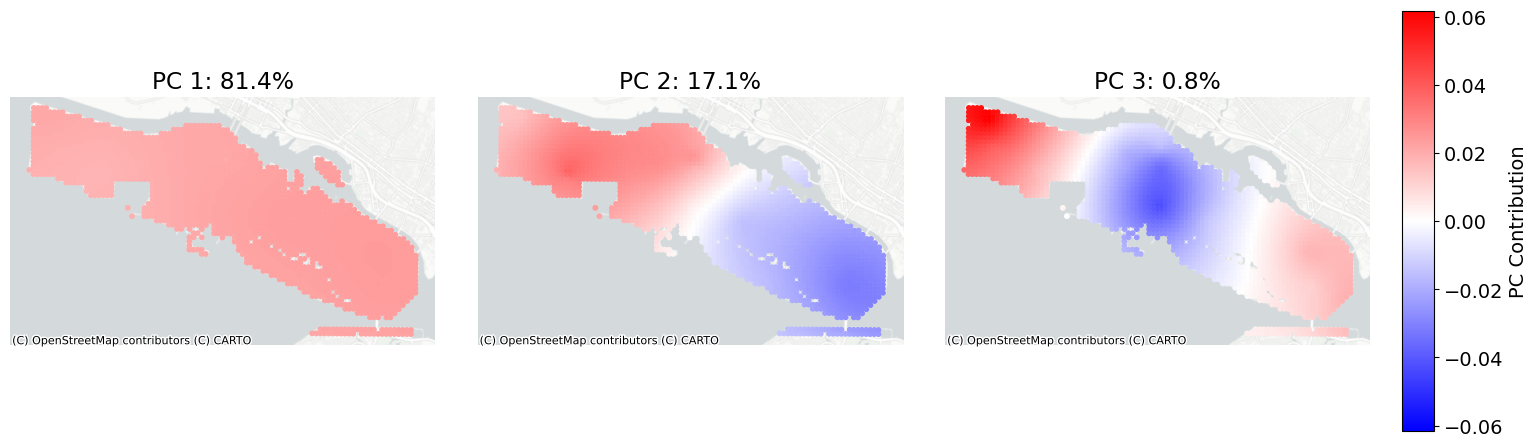

In [17]:
points = setup_grid(geoplot='./geojson/alameda_city.geojson')
points = points.to_crs('EPSG:4326')
loadings = pca.components_.T  # Shape: (n_points, n_pcs)
num_pcs_to_plot = 3  # First 6 PCs
for i in range(num_pcs_to_plot):
    points[f'PC_{i + 1}'] = loadings[:, i]

vmin = -max(abs(points[[f'PC_{i + 1}' for i in range(num_pcs_to_plot)]].min().min()),points[[f'PC_{i + 1}' for i in range(num_pcs_to_plot)]].max().max())
vmax = -vmin  # Symmetric around 0

fig, axes = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=False)
plt.rcParams.update({'font.size': 14})
axes = axes.flatten()

# Plot each PC's contribution
for i in range(num_pcs_to_plot):
    ax = axes[i]
    points.plot(
        column=f'PC_{i + 1}', 
        ax=ax, 
        cmap='bwr', 
        legend=False, 
        vmin=vmin, 
        vmax=vmax, 
        markersize=10
    )
    ctx.add_basemap(ax, crs=points.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
    ax.set_title(f'PC {i + 1}: {explained_variance[i]*100:.1f}%')
    ax.axis('off')

# Add a shared colorbar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the colorbar position
cbar = mpl.colorbar.ColorbarBase(
    cbar_ax, 
    cmap='bwr', 
    norm=norm, 
    orientation='vertical', 
    label='PC Contribution'
)

# Adjust spacing between subplots and margins
plt.subplots_adjust(
    left=0.05,  # Left margin
    right=0.9,  # Reserve space for the colorbar
    top=0.9,    # Top margin
    bottom=0.1, # Bottom margin
    wspace=0.1, # Space between columns
    hspace=0.05  # Space between rows
)

c:\Users\Emily\miniconda3\envs\Kh_env\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Text(0.5, 1.0, '(b)')

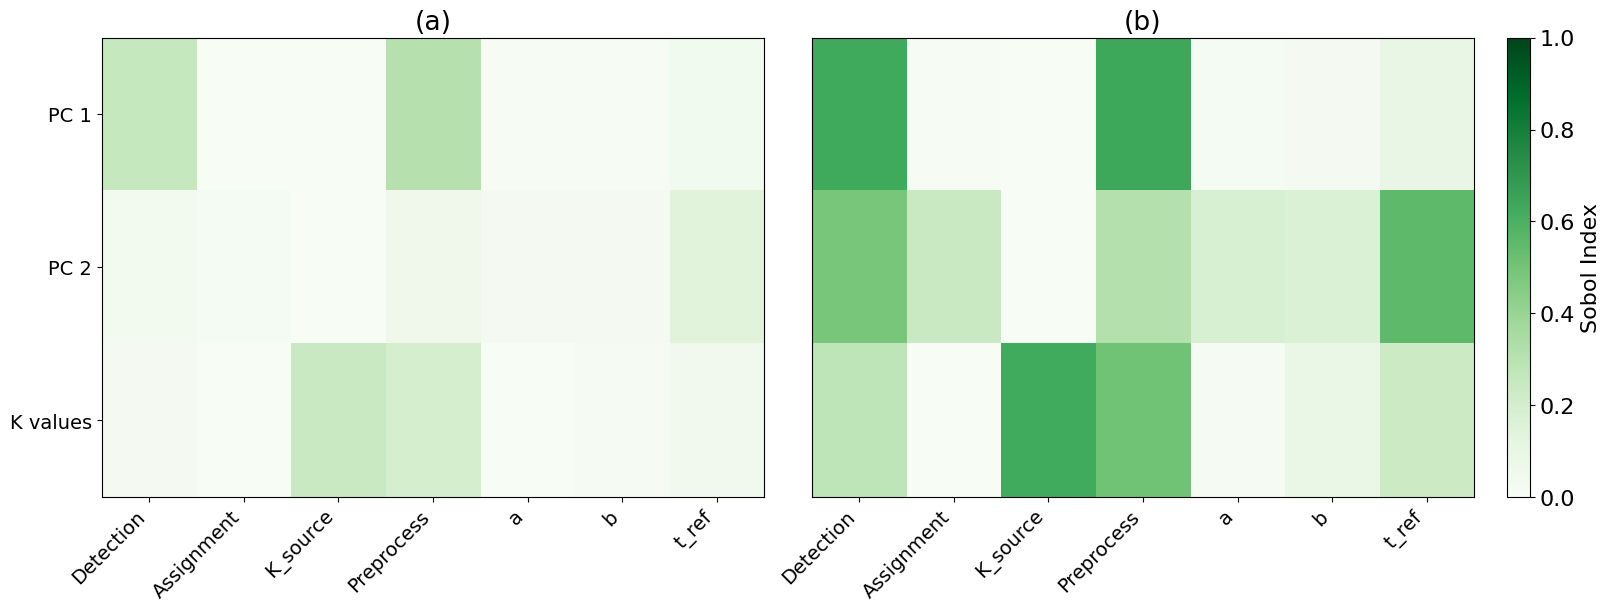

In [18]:
Y_k = (K_df['hk_m_day_1'].values - np.mean(K_df['hk_m_day_1'].values))/ np.std(K_df['hk_m_day_1'].values)  #np.log

Si_k   = sobol.analyze(problem, Y_k)

## append with si_K and plot
Si_list = S1_matrix.tolist()
Si_list.append(Si_k['S1'])
S1_matrix = np.array(Si_list)
## Plot the higher order sobol for PCs and K
ST_matrix = np.array([Si['ST'] for Si in results])  # Shape: (num_pcs, num_vars)
ST_list = ST_matrix.tolist()
ST_list.append(Si_k['ST'])
ST_matrix = np.array(ST_list)

## make a plot with two side-by side subfigures that are s1 and sT
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
plt.rcParams.update({'font.size': 16})
axes = axes.flatten()
ax = axes[0]
im = ax.imshow(S1_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_yticks(range(num_pcs+1))
ax.set_yticklabels([f'PC {i+1}' for i in range(num_pcs)] + ['K values'])
# fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('(a)')

ax = axes[1]
im = ax.imshow(ST_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
# remove y ticks
ax.set_yticks([])
fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('(b)')
# plt.savefig('./figures/sobol_indices.png', format='png', dpi=1000,bbox_inches='tight')
# plt.savefig('./figures/sobol_indices.pdf', format='pdf', dpi=1000,bbox_inches='tight')


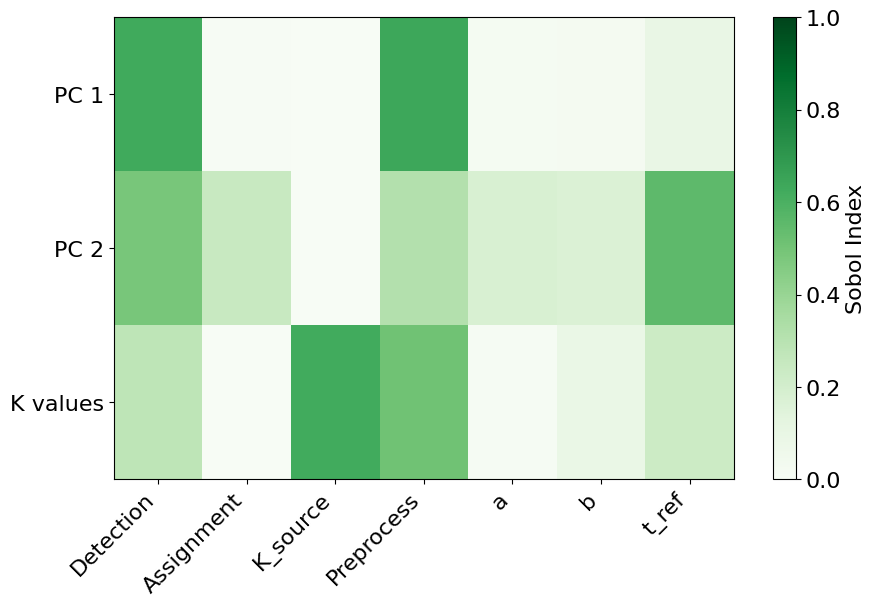

In [19]:
# plot just the total sobol indices

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(ST_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_yticks(range(num_pcs+1))
ax.set_yticklabels([f'PC {i+1}' for i in range(num_pcs)] + ['K values'])
fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
plt.show()

Now I want to combine the PCs that explain 95% of variance and make a plot that combines K values (as in for all layers) and then has a fill/ ybm line and sobol indices for each

c:\Users\Emily\miniconda3\envs\Kh_env\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


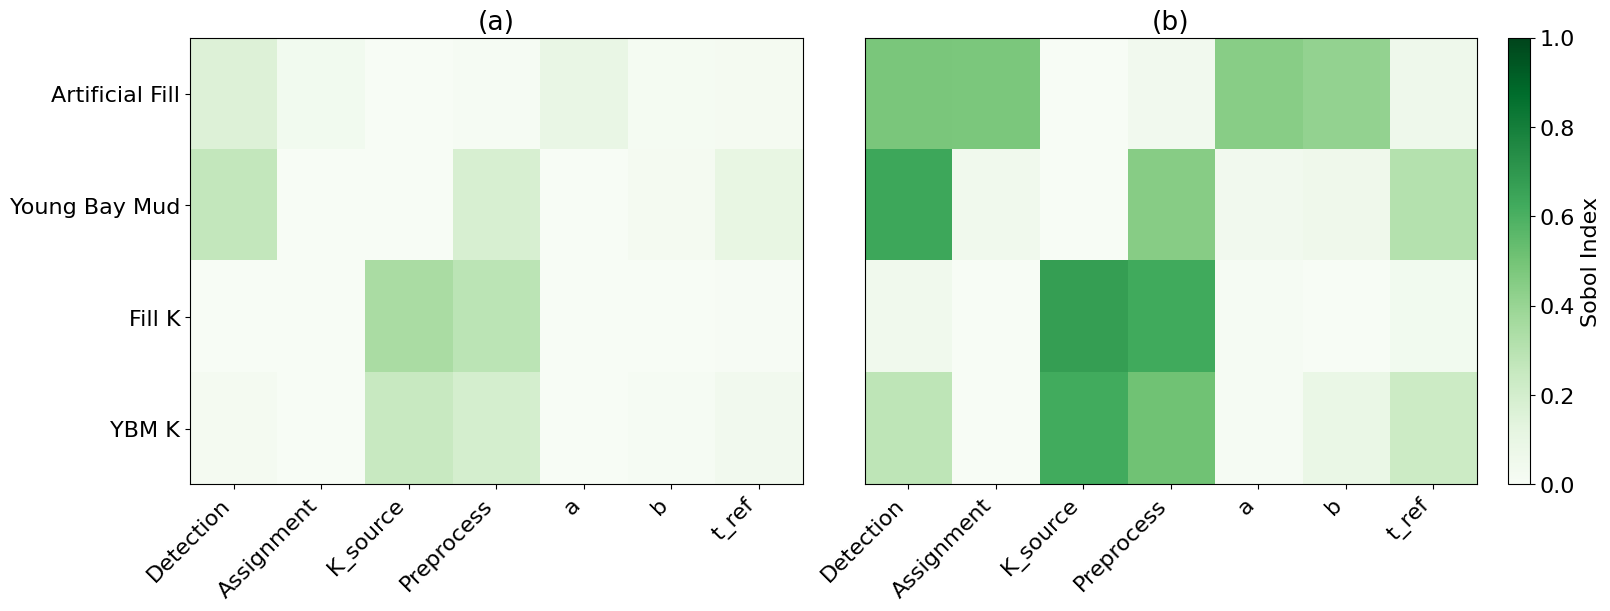

In [20]:
y_fill = np.sum(fill_pca[:,:4],axis=1)
y_ybm = np.sum(ybm_pca[:,:2],axis=1)
y_k_fill = (K_df['hk_m_day_0'].values - np.mean(K_df['hk_m_day_0'].values))/ np.std(K_df['hk_m_day_0'].values)  #np.log
y_k_ybm = (K_df['hk_m_day_1'].values - np.mean(K_df['hk_m_day_1'].values))/ np.std(K_df['hk_m_day_1'].values)  #np.log

Si_fill   = sobol.analyze(problem, y_fill,calc_second_order=True)
Si_ybm   = sobol.analyze(problem, y_ybm,calc_second_order=True)
Si_k_fill   = sobol.analyze(problem, y_k_fill,calc_second_order=True)
Si_k_ybm   = sobol.analyze(problem, y_k_ybm,calc_second_order=True)

## append them all together and plot
S1_matrix = np.array([Si_fill['S1'], Si_ybm['S1'], Si_k_fill['S1'], Si_k_ybm['S1']])
ST_matrix = np.array([Si_fill['ST'], Si_ybm['ST'], Si_k_fill['ST'], Si_k_ybm['ST']])
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
plt.rcParams.update({'font.size': 16})
axes = axes.flatten()
ax = axes[0]
im = ax.imshow(S1_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_yticks(range(4))
ax.set_yticklabels(['Artificial Fill', 'Young Bay Mud', 'Fill K', 'YBM K'])
# fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('(a)')
ax = axes[1]
im = ax.imshow(ST_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
# remove y ticks
ax.set_yticks([])
fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('(b)')
plt.savefig('./figures/sobol_indices.png', format='png', dpi=1000,bbox_inches='tight')
plt.savefig('./figures/sobol_indices.pdf', format='pdf', dpi=1000,bbox_inches='tight')

C:\Users\Emily\AppData\Local\Temp\ipykernel_47332\3050955823.py:45: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(


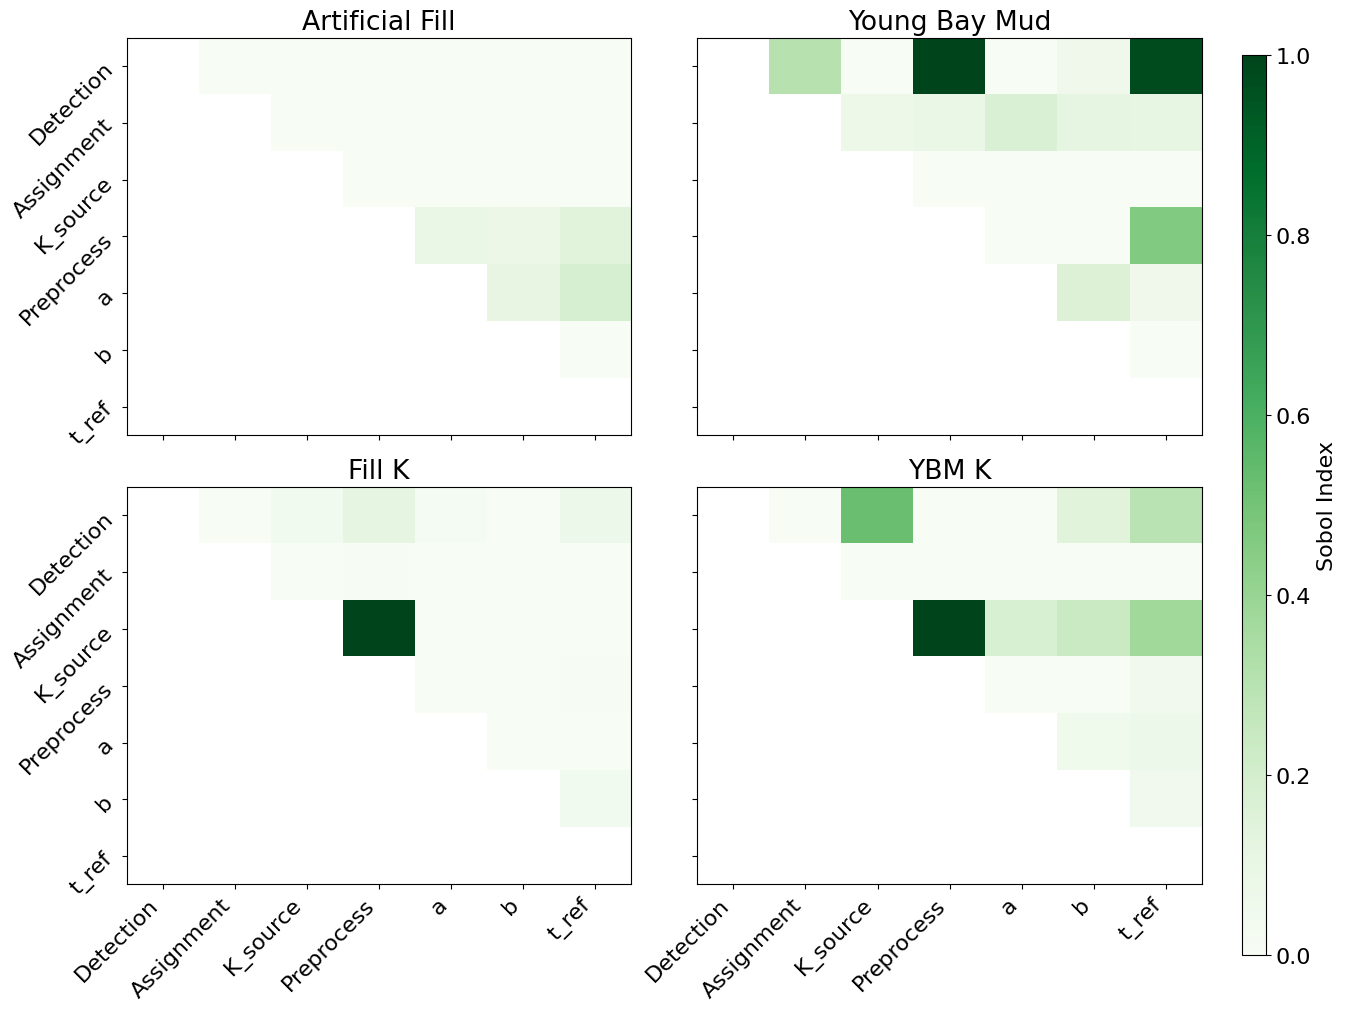

In [21]:
## and plot second order indices for each
S2_fill = np.array([Si_fill['S2']])
S2_ybm = np.array([Si_ybm['S2']])
S2_k_fill = np.array([Si_k_fill['S2']])
S2_k_ybm = np.array([Si_k_ybm['S2']])

fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)
plt.rcParams.update({'font.size': 16})
axes = axes.flatten()
ax = axes[0]
im = ax.imshow(S2_fill[0], aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=0.1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels([])
ax.set_yticks(range(num_vars))
ax.set_yticklabels(problem['names'], rotation=45, ha='right')
# fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('Artificial Fill')
ax = axes[1]
im = ax.imshow(S2_ybm[0], aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=0.1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels([])
ax.set_yticks(range(num_vars))
ax.set_yticklabels([])
# fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('Young Bay Mud')
ax = axes[2]
im = ax.imshow(S2_k_fill[0], aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=0.1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_yticks(range(num_vars))
ax.set_yticklabels(problem['names'], rotation=45, ha='right')
# fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('Fill K')
ax = axes[3]
im = ax.imshow(S2_k_ybm[0], aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=0.1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_yticks(range(num_vars))
ax.set_yticklabels([])
# fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('YBM K')

# make one colorbar on the right
# shift plots to the left
plt.subplots_adjust(
    left=0.05,  # Left margin
    right=0.7,  # Reserve space for the colorbar
    top=0.9,    # Top margin
    bottom=0.1, # Bottom margin
    wspace=0.1, # Space between columns
    hspace=0.05  # Space between rows
)
# add a cbar axis
cbar_ax = fig.add_axes([1.03, 0.05, 0.02, 0.9])  # Adjust the colorbar position
cbar = mpl.colorbar.ColorbarBase(
    cbar_ax, 
    cmap='Greens', 
    orientation='vertical', 
    label='Sobol Index'
)

plt.savefig('./figures/sobol_indices_2.png', format='png', dpi=1000,bbox_inches='tight')
plt.savefig('./figures/sobol_indices_2.pdf', format='pdf', dpi=1000,bbox_inches='tight')
